In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.5f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

In [ ]:
df = pd.read_csv("data/full_data/TPS_cancel_data_Final.csv")

In [4]:
df

,sha2_hash,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,10.00000,약정만료전 12개월이상,733,Y,3.00000,3개월내없음,N,N,60대,0.00000,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,Y,I/B,0.00000,약정만료전 9~12개월,764,Y,3.00000,일주일내,Y,N,60대,6.72000,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,10.00000,약정만료전 9~12개월,794,Y,3.00000,3주일전,N,N,60대,9.86000,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,10.00000,약정만료전 9~12개월,825,Y,3.00000,4주일전,N,N,60대,5.95000,10,5,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,0.00000,약정만료전 6~9개월,855,Y,3.00000,일주일내,N,N,60대,4.03000,9,6,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,10.00000,약정만료후 12개월이상,2338,N,1.00000,일주일내,N,N,50대,2.03000,-40,8,N
21483375,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,10.00000,약정만료후 12개월이상,2368,N,1.00000,일주일내,N,N,50대,2.91000,-41,9,N
21483376,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,10.00000,약정만료후 12개월이상,2399,N,1.00000,2주일전,Y,N,50대,1.97000,-42,10,N
21483377,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,0.00000,약정만료후 12개월이상,2429,N,1.00000,3개월내없음,N,N,50대,0.00000,-43,11,N


LightGBM 학습

In [19]:
# 2월 ~ 9월 train
# 10월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
val = df[df['p_mt'] == 10]
test = df[df['p_mt'] == 11]

# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

train = train.drop(columns=['sha2_hash','p_mt'])
val = val.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])

object
object
object


In [20]:
from sklearn.utils import resample

# 데이터 분리
df_Y = train[train['churn'] == 'Y']
df_N = train[train['churn'] == 'N']

# Y의 데이터 개수와 비율에 따른 N의 샘플 개수 계산
y_count = len(df_Y)  # Y 데이터 개수
n_count_target = int((6 / 4) * y_count)  # 6:4 비율로 N 데이터 개수 계산

# N 데이터를 랜덤 샘플링
df_N_downsampled = resample(
    df_N,
    replace=False,  # 복원 샘플링 하지 않음
    n_samples=n_count_target,  # 목표 샘플 개수
    random_state=42  # 재현성을 위한 시드
)

# 언더샘플링된 데이터 결합
train_balanced = pd.concat([df_Y, df_N_downsampled])

# 결과 섞기 (선택 사항)
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 확인
print("최종 데이터 분포:")
print(train_balanced['churn'].value_counts())

train = train_balanced

최종 데이터 분포:
churn
N    158559
Y    105706
Name: count, dtype: int64


In [21]:
categorical_cols = train.select_dtypes(include=['object']).columns

# Train에는 없고 Validation에만 있는 값 찾기
unseen_values = {}

for col in categorical_cols:
    train_unique = set(train[col].unique())
    val_unique = set(val[col].unique())

    unseen = val_unique - train_unique
    if unseen:
        unseen_values[col] = unseen

# 결과 출력
print(unseen_values)

{'PROD_NM_GRP': {'기타'}, 'INHOME_RATE': {'100.0'}}


In [22]:
val = val[val['PROD_NM_GRP'] != '기타'].reset_index(drop=True)
test = test[test['PROD_NM_GRP'] != '기타'].reset_index(drop=True)

val = val[val['INHOME_RATE'] != '100.0'].reset_index(drop=True)
test = test[test['INHOME_RATE'] != '100.0'].reset_index(drop=True)

In [9]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [10]:
# 레이블 인코딩 맵핑

for col in categorical_cols:
    unique_mapping = {orig: enc for orig, enc in zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_))}
    
    mapping_str = ", ".join([f"{key}: {value}" for key, value in unique_mapping.items()])
    
    print(f"컬럼: {col}")
    print(mapping_str)
    print("-" * 50)  # 구분선


컬럼: MEDIA_NM_GRP
HD: 0, UHD: 1, 기타: 2
--------------------------------------------------
컬럼: PROD_NM_GRP
베이직: 0, 세이버: 1, 스탠다드: 2, 이코노미: 3, 프리미엄: 4
--------------------------------------------------
컬럼: AGMT_KIND_NM
신규: 0, 약정갱신: 1, 약정승계: 2, 약정연장: 3, 약정축소: 4, 재약정: 5, 정보없음: 6
--------------------------------------------------
컬럼: STB_RES_1M_YN
N: 0, Y: 1
--------------------------------------------------
컬럼: SCRB_PATH_NM_GRP
I/B: 0, O/B: 1, 기타: 2, 렌탈제휴: 3, 일반상담: 4, 임직원: 5, 전략채널: 6, 정보없음: 7, 직영몰: 8, 현장경로: 9
--------------------------------------------------
컬럼: INHOME_RATE
0.0: 0, 10.0: 1, 20.0: 2, 30.0: 3, 40.0: 4, 50.0: 5, 60.0: 6, 70.0: 7, 80.0: 8, 90.0: 9
--------------------------------------------------
컬럼: AGMT_END_SEG
약정만료 1개월: 0, 약정만료전 12개월이상: 1, 약정만료전 1~2개월: 2, 약정만료전 1개월: 3, 약정만료전 2~3개월: 4, 약정만료전 3~6개월: 5, 약정만료전 6~9개월: 6, 약정만료전 9~12개월: 7, 약정만료후 12개월이상: 8, 약정만료후 1개월~2개월: 9, 약정만료후 2개월~3개월: 10, 약정만료후 3~6개월: 11, 약정만료후 6~9개월: 12, 약정만료후 9~12개월: 13
--------------------------------------

In [11]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [12]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

Validation Accuracy: 0.82

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1934319
           1       0.03      0.73      0.05     14325

    accuracy                           0.82   1948644
   macro avg       0.51      0.77      0.48   1948644
weighted avg       0.99      0.82      0.89   1948644


Confusion Matrix (Validation):
[[1579140  355179]
 [   3918   10407]]


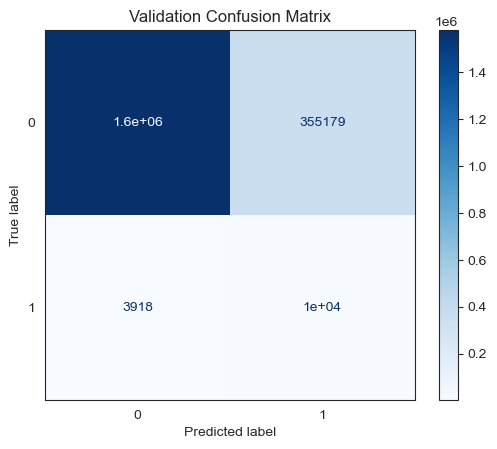

Validation AUC-ROC: 0.85


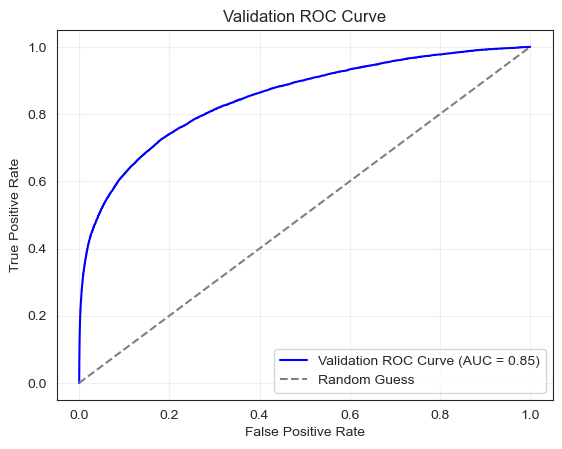

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Test Performance:
Test Accuracy: 0.82
Test AUC-ROC: 0.85
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1932409
           1       0.03      0.73      0.05     13176

    accuracy                           0.82   1945585
   macro avg       0.51      0.78      0.48   1945585
weighted avg       0.99      0.82      0.89   1945585



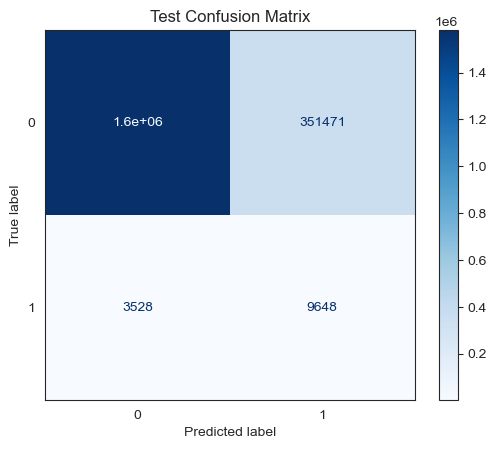

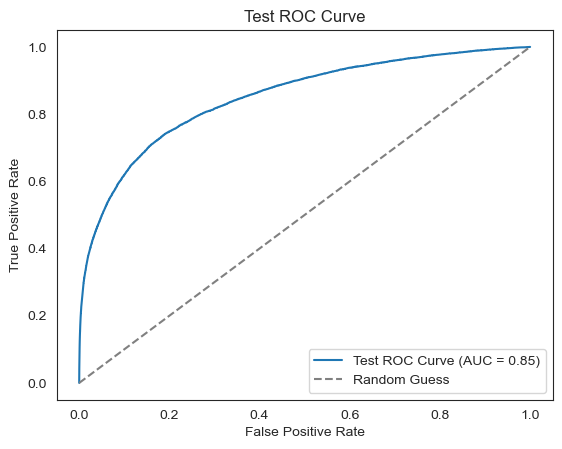

In [14]:
# -----------------------------------------------------------
# 4. 테스트 데이터 평가
# -----------------------------------------------------------
# 테스트 데이터 예측
# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_test = test.drop(columns=['churn'])
y_test = test['churn']

test_predictions = lgbm_model.predict(X_test)
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, test_predictions)
test_auc = roc_auc_score(y_test, test_probabilities)

print("\nTest Performance:")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test AUC-ROC: {test_auc:.2f}")
print(classification_report(y_test, test_predictions))

# Confusion Matrix 시각화
cm_test = confusion_matrix(y_test, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lgbm_model.classes_)
disp_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

하이퍼 파라미터 튜닝을 진행해보자. with Optuna

#### 📌 Optuna란?

##### 🔹 Optuna 개요
**Optuna**는 **자동화된 하이퍼파라미터 최적화 라이브러리**로,   
머신러닝 모델의 **최적 하이퍼파라미터 조합을 찾는 과정**을 자동으로 수행합니다.

##### 🔹 Optuna의 특징
- ✅ **자동 탐색**: 주어진 범위에서 최적의 하이퍼파라미터를 찾음
- ✅ **베이지안 최적화 지원**: 효율적인 탐색을 수행
- ✅ **Pruning 기능**: 성능이 낮은 모델을 조기 종료하여 시간 절약
- ✅ **병렬 실행 가능**: 여러 개의 탐색(trial)을 동시에 실행 가능

---

In [15]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, f1_score

# ✅ 기존 train, val 데이터셋 사용
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# ✅ Objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 트리 개수
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # 학습률
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # 잎 노드 수
        'max_depth': trial.suggest_int('max_depth', -1, 50),  # 최대 깊이 (-1은 제한 없음)
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),  # 최소 잎 노드 샘플 수
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 피처 샘플링 비율
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10.0),  # L1 정규화
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10.0),  # L2 정규화
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0)  # 클래스 가중치
    }

    # ✅ LightGBM 모델 생성
    model = LGBMClassifier(**param, random_state=42)

    # ✅ 조기 종료 기능 추가 (early_stopping_rounds 사용)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  
        eval_metric='f1',  
        early_stopping_rounds=30,  
        verbose=False  # 학습 과정 로그 출력을 줄이기 위해 False 설정
    )

    # ✅ 검증 데이터 예측
    val_predictions = model.predict(X_val)

    # ✅ Confusion Matrix 계산
    cm = confusion_matrix(y_val, val_predictions)
    tn, fp, fn, tp = cm.ravel()

    # ✅ F1-Score 계산
    f1 = f1_score(y_val, val_predictions)

    # ✅ False Negative(FN) 및 True Positive(TP) 기준 추가
    if fn > 5000:  # False Negative(FN)가 너무 많으면 제외
        return 0
    if tp < 9000:  # True Positive(TP)가 너무 낮으면 제외
        return 0

    return f1  # ✅ 최적화 목표: F1-Score 최대화

# ✅ Optuna 실행
study = optuna.create_study(direction='maximize')  # F1-Score를 최대화하는 방향으로 최적화
study.optimize(objective, n_trials=50)  # 50회 최적화 실행

# ✅ 최적의 하이퍼파라미터 출력
print("Best Parameters:", study.best_params)
print("Best F1-Score:", study.best_value)


[I 2025-02-03 16:05:17,618] A new study created in memory with name: no-name-dea944fe-aad5-4ced-834a-885261b2950b


[LightGBM] [Warning] lambda_l1 is set=2.727870302348323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.727870302348323
[LightGBM] [Warning] lambda_l2 is set=7.961734085410131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.961734085410131


[I 2025-02-03 16:05:22,059] Trial 0 finished with value: 0.05591469931288 and parameters: {'n_estimators': 808, 'learning_rate': 0.15071033721580926, 'num_leaves': 115, 'max_depth': 34, 'min_child_samples': 198, 'subsample': 0.5698684441053143, 'colsample_bytree': 0.7880375958930252, 'lambda_l1': 2.727870302348323, 'lambda_l2': 7.961734085410131, 'scale_pos_weight': 1.7049632577637148}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=0.8853582789001591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8853582789001591
[LightGBM] [Warning] lambda_l2 is set=0.3721667069100332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3721667069100332


[I 2025-02-03 16:05:25,541] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 545, 'learning_rate': 0.14291390277254026, 'num_leaves': 113, 'max_depth': 27, 'min_child_samples': 186, 'subsample': 0.937172829506087, 'colsample_bytree': 0.5183509347095021, 'lambda_l1': 0.8853582789001591, 'lambda_l2': 0.3721667069100332, 'scale_pos_weight': 9.829143159766094}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=6.8992677489391605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8992677489391605
[LightGBM] [Warning] lambda_l2 is set=1.453535416129207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.453535416129207


[I 2025-02-03 16:05:29,059] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 649, 'learning_rate': 0.07171302253819406, 'num_leaves': 128, 'max_depth': 46, 'min_child_samples': 54, 'subsample': 0.8974430918187011, 'colsample_bytree': 0.5270031002678471, 'lambda_l1': 6.8992677489391605, 'lambda_l2': 1.453535416129207, 'scale_pos_weight': 2.2336962952683903}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=3.7102124755193833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7102124755193833
[LightGBM] [Warning] lambda_l2 is set=7.187385801800876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.187385801800876


[I 2025-02-03 16:05:32,576] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 286, 'learning_rate': 0.03147136744643894, 'num_leaves': 124, 'max_depth': 34, 'min_child_samples': 169, 'subsample': 0.7536619149039093, 'colsample_bytree': 0.989845785409599, 'lambda_l1': 3.7102124755193833, 'lambda_l2': 7.187385801800876, 'scale_pos_weight': 6.617723301499851}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=7.880370264342314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.880370264342314
[LightGBM] [Warning] lambda_l2 is set=2.833494807596323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.833494807596323


[I 2025-02-03 16:05:35,755] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 751, 'learning_rate': 0.05667667248657281, 'num_leaves': 23, 'max_depth': 21, 'min_child_samples': 117, 'subsample': 0.8740823022098168, 'colsample_bytree': 0.9846006452932606, 'lambda_l1': 7.880370264342314, 'lambda_l2': 2.833494807596323, 'scale_pos_weight': 7.381525580032184}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=9.065409636154062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.065409636154062
[LightGBM] [Warning] lambda_l2 is set=7.196051560076868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.196051560076868


[I 2025-02-03 16:05:39,318] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 417, 'learning_rate': 0.1989203080435226, 'num_leaves': 126, 'max_depth': 30, 'min_child_samples': 35, 'subsample': 0.8487700550823025, 'colsample_bytree': 0.8709145321198527, 'lambda_l1': 9.065409636154062, 'lambda_l2': 7.196051560076868, 'scale_pos_weight': 4.358375338648611}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=7.298444961091293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.298444961091293
[LightGBM] [Warning] lambda_l2 is set=5.675490286329192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.675490286329192


[I 2025-02-03 16:05:42,871] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 230, 'learning_rate': 0.14529515449466207, 'num_leaves': 104, 'max_depth': 26, 'min_child_samples': 97, 'subsample': 0.6972780475351771, 'colsample_bytree': 0.937685482766014, 'lambda_l1': 7.298444961091293, 'lambda_l2': 5.675490286329192, 'scale_pos_weight': 3.8649058446501035}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=7.832754698636007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.832754698636007
[LightGBM] [Warning] lambda_l2 is set=1.464657736141387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.464657736141387


[I 2025-02-03 16:05:46,497] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 105, 'learning_rate': 0.19875501997662184, 'num_leaves': 104, 'max_depth': 18, 'min_child_samples': 136, 'subsample': 0.8598814387333903, 'colsample_bytree': 0.6070047842700834, 'lambda_l1': 7.832754698636007, 'lambda_l2': 1.464657736141387, 'scale_pos_weight': 9.814907972723871}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=9.725643715877888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.725643715877888
[LightGBM] [Warning] lambda_l2 is set=4.140949115151814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.140949115151814


[I 2025-02-03 16:05:49,689] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 499, 'learning_rate': 0.04883569228485811, 'num_leaves': 41, 'max_depth': 18, 'min_child_samples': 78, 'subsample': 0.803732974534624, 'colsample_bytree': 0.6618285856687312, 'lambda_l1': 9.725643715877888, 'lambda_l2': 4.140949115151814, 'scale_pos_weight': 9.445032939552192}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=1.935562523868798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.935562523868798
[LightGBM] [Warning] lambda_l2 is set=5.70268978950822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.70268978950822


[I 2025-02-03 16:05:53,246] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 370, 'learning_rate': 0.02200810526748639, 'num_leaves': 146, 'max_depth': 44, 'min_child_samples': 186, 'subsample': 0.6694418040434493, 'colsample_bytree': 0.9811778838266729, 'lambda_l1': 1.935562523868798, 'lambda_l2': 5.70268978950822, 'scale_pos_weight': 9.076407665619847}. Best is trial 0 with value: 0.05591469931288.


[LightGBM] [Warning] lambda_l1 is set=4.641944310999863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.641944310999863
[LightGBM] [Warning] lambda_l2 is set=9.197916523794223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.197916523794223


[I 2025-02-03 16:06:23,912] Trial 10 finished with value: 0.06978093664644941 and parameters: {'n_estimators': 994, 'learning_rate': 0.11383109314408676, 'num_leaves': 69, 'max_depth': 2, 'min_child_samples': 145, 'subsample': 0.5076849374977488, 'colsample_bytree': 0.7939112737232251, 'lambda_l1': 4.641944310999863, 'lambda_l2': 9.197916523794223, 'scale_pos_weight': 1.0870176448925175}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.391316249976125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.391316249976125
[LightGBM] [Warning] lambda_l2 is set=8.946469301994707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.946469301994707


[I 2025-02-03 16:06:47,593] Trial 11 finished with value: 0.06670863928706837 and parameters: {'n_estimators': 997, 'learning_rate': 0.11661696773639672, 'num_leaves': 70, 'max_depth': 2, 'min_child_samples': 149, 'subsample': 0.510314247932745, 'colsample_bytree': 0.7953262882097729, 'lambda_l1': 4.391316249976125, 'lambda_l2': 8.946469301994707, 'scale_pos_weight': 1.139197697653901}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.94666648630682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.94666648630682
[LightGBM] [Warning] lambda_l2 is set=9.926361239730396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.926361239730396


[I 2025-02-03 16:07:50,097] Trial 12 finished with value: 0.05785320716725801 and parameters: {'n_estimators': 988, 'learning_rate': 0.09798176861883966, 'num_leaves': 71, 'max_depth': -1, 'min_child_samples': 144, 'subsample': 0.500719696076174, 'colsample_bytree': 0.7780918412409159, 'lambda_l1': 4.94666648630682, 'lambda_l2': 9.926361239730396, 'scale_pos_weight': 1.3955045408837492}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.770453294811728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.770453294811728
[LightGBM] [Warning] lambda_l2 is set=9.860799638748473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.860799638748473


[I 2025-02-03 16:07:53,402] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.08715518962072556, 'num_leaves': 69, 'max_depth': 0, 'min_child_samples': 151, 'subsample': 0.5961878394672383, 'colsample_bytree': 0.8526334905877971, 'lambda_l1': 4.770453294811728, 'lambda_l2': 9.860799638748473, 'scale_pos_weight': 3.2461596794557948}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=6.032668848382561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032668848382561
[LightGBM] [Warning] lambda_l2 is set=8.210304009453727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.210304009453727


[I 2025-02-03 16:08:12,077] Trial 14 finished with value: 0.06823237859900086 and parameters: {'n_estimators': 862, 'learning_rate': 0.11675355154299724, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 110, 'subsample': 0.5019728884244564, 'colsample_bytree': 0.707423182872646, 'lambda_l1': 6.032668848382561, 'lambda_l2': 8.210304009453727, 'scale_pos_weight': 1.139094871586962}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=6.140301543633981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.140301543633981
[LightGBM] [Warning] lambda_l2 is set=8.33677922644002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.33677922644002


[I 2025-02-03 16:08:15,203] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 854, 'learning_rate': 0.11674762087161576, 'num_leaves': 50, 'max_depth': 9, 'min_child_samples': 110, 'subsample': 0.5993157471819415, 'colsample_bytree': 0.6906624501221806, 'lambda_l1': 6.140301543633981, 'lambda_l2': 8.33677922644002, 'scale_pos_weight': 2.7602010833514745}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=6.207608769182027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207608769182027
[LightGBM] [Warning] lambda_l2 is set=6.933187243366509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.933187243366509


[I 2025-02-03 16:08:18,535] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 870, 'learning_rate': 0.16744437685933677, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 83, 'subsample': 0.9965336517709297, 'colsample_bytree': 0.700417230148404, 'lambda_l1': 6.207608769182027, 'lambda_l2': 6.933187243366509, 'scale_pos_weight': 5.004099439259844}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=3.4452540127388787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4452540127388787
[LightGBM] [Warning] lambda_l2 is set=4.6613094620102435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6613094620102435


[I 2025-02-03 16:08:21,706] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 686, 'learning_rate': 0.12373680015496316, 'num_leaves': 49, 'max_depth': 8, 'min_child_samples': 128, 'subsample': 0.6617012295082172, 'colsample_bytree': 0.6085584226941525, 'lambda_l1': 3.4452540127388787, 'lambda_l2': 4.6613094620102435, 'scale_pos_weight': 5.586703155726251}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=0.19578741771772012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19578741771772012
[LightGBM] [Warning] lambda_l2 is set=8.881717656409199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.881717656409199


[I 2025-02-03 16:08:24,733] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 902, 'learning_rate': 0.08068993138005116, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.5602283029659081, 'colsample_bytree': 0.8448586619959846, 'lambda_l1': 0.19578741771772012, 'lambda_l2': 8.881717656409199, 'scale_pos_weight': 2.719655460040147}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.351414883660771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.351414883660771
[LightGBM] [Warning] lambda_l2 is set=6.03368841391195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.03368841391195


[I 2025-02-03 16:08:27,875] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 655, 'learning_rate': 0.17124194197495507, 'num_leaves': 27, 'max_depth': 14, 'min_child_samples': 67, 'subsample': 0.5438326233294887, 'colsample_bytree': 0.7278415431063949, 'lambda_l1': 5.351414883660771, 'lambda_l2': 6.03368841391195, 'scale_pos_weight': 3.652440883184936}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.964750311876299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.964750311876299
[LightGBM] [Warning] lambda_l2 is set=3.780474104882911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.780474104882911


[I 2025-02-03 16:08:44,153] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 768, 'learning_rate': 0.10030833019936479, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 165, 'subsample': 0.6215303864881015, 'colsample_bytree': 0.6468014813980074, 'lambda_l1': 5.964750311876299, 'lambda_l2': 3.780474104882911, 'scale_pos_weight': 1.0320986237572143}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.097344007695349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.097344007695349
[LightGBM] [Warning] lambda_l2 is set=8.914365762235134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.914365762235134


[I 2025-02-03 16:09:09,828] Trial 21 finished with value: 0.06466416786934266 and parameters: {'n_estimators': 943, 'learning_rate': 0.11657554032636196, 'num_leaves': 76, 'max_depth': 1, 'min_child_samples': 123, 'subsample': 0.5180920619516985, 'colsample_bytree': 0.8132709673911328, 'lambda_l1': 4.097344007695349, 'lambda_l2': 8.914365762235134, 'scale_pos_weight': 1.0547244764654764}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.1389980346496955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1389980346496955
[LightGBM] [Warning] lambda_l2 is set=9.129442907160144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.129442907160144


[I 2025-02-03 16:09:12,681] Trial 22 finished with value: 0.0 and parameters: {'n_estimators': 921, 'learning_rate': 0.12717099788569808, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 159, 'subsample': 0.5034777698178762, 'colsample_bytree': 0.7477626363029183, 'lambda_l1': 4.1389980346496955, 'lambda_l2': 9.129442907160144, 'scale_pos_weight': 2.1044511306254163}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=2.567568532487782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.567568532487782
[LightGBM] [Warning] lambda_l2 is set=7.837729043415599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.837729043415599


[I 2025-02-03 16:09:15,705] Trial 23 finished with value: 0.0 and parameters: {'n_estimators': 982, 'learning_rate': 0.10132021939992689, 'num_leaves': 38, 'max_depth': 13, 'min_child_samples': 96, 'subsample': 0.5500781231291271, 'colsample_bytree': 0.9028350438524866, 'lambda_l1': 2.567568532487782, 'lambda_l2': 7.837729043415599, 'scale_pos_weight': 2.0419074417846836}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.449430908523275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.449430908523275
[LightGBM] [Warning] lambda_l2 is set=6.5370473827286215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.5370473827286215


[I 2025-02-03 16:09:18,454] Trial 24 finished with value: 0.0 and parameters: {'n_estimators': 826, 'learning_rate': 0.13297923113663407, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 137, 'subsample': 0.6464444275576677, 'colsample_bytree': 0.8019722472341257, 'lambda_l1': 5.449430908523275, 'lambda_l2': 6.5370473827286215, 'scale_pos_weight': 2.880123277282359}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.413894340681715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.413894340681715
[LightGBM] [Warning] lambda_l2 is set=9.554715941270874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.554715941270874


[I 2025-02-03 16:10:20,683] Trial 25 finished with value: 0.0520586080954886 and parameters: {'n_estimators': 890, 'learning_rate': 0.16320198955475845, 'num_leaves': 95, 'max_depth': 15, 'min_child_samples': 104, 'subsample': 0.7404457461130378, 'colsample_bytree': 0.7423683483387026, 'lambda_l1': 4.413894340681715, 'lambda_l2': 9.554715941270874, 'scale_pos_weight': 1.584124337218115}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=2.9352891599216524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9352891599216524
[LightGBM] [Warning] lambda_l2 is set=8.302912530280244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.302912530280244


[I 2025-02-03 16:10:24,016] Trial 26 finished with value: 0.0 and parameters: {'n_estimators': 741, 'learning_rate': 0.10975773382872041, 'num_leaves': 63, 'max_depth': 8, 'min_child_samples': 156, 'subsample': 0.5883092815836127, 'colsample_bytree': 0.8307008861203955, 'lambda_l1': 2.9352891599216524, 'lambda_l2': 8.302912530280244, 'scale_pos_weight': 2.377741633729417}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=1.4057936380021827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4057936380021827
[LightGBM] [Warning] lambda_l2 is set=7.809723794832099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.809723794832099


[I 2025-02-03 16:10:40,472] Trial 27 finished with value: 0.0 and parameters: {'n_estimators': 936, 'learning_rate': 0.08453475548245475, 'num_leaves': 36, 'max_depth': -1, 'min_child_samples': 128, 'subsample': 0.5305497485653226, 'colsample_bytree': 0.887546391210672, 'lambda_l1': 1.4057936380021827, 'lambda_l2': 7.809723794832099, 'scale_pos_weight': 1.0349550078408445}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=6.825127240903541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.825127240903541
[LightGBM] [Warning] lambda_l2 is set=8.302504589853847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.302504589853847


[I 2025-02-03 16:10:43,132] Trial 28 finished with value: 0.0 and parameters: {'n_estimators': 591, 'learning_rate': 0.1348060277080322, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 173, 'subsample': 0.6279450691272705, 'colsample_bytree': 0.7722393822773297, 'lambda_l1': 6.825127240903541, 'lambda_l2': 8.302504589853847, 'scale_pos_weight': 8.200427428124819}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=2.981809300131528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981809300131528
[LightGBM] [Warning] lambda_l2 is set=9.37859058733588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.37859058733588


[I 2025-02-03 16:10:47,819] Trial 29 finished with value: 0.05278405073108419 and parameters: {'n_estimators': 821, 'learning_rate': 0.06866896016086554, 'num_leaves': 92, 'max_depth': 20, 'min_child_samples': 199, 'subsample': 0.5673741664968033, 'colsample_bytree': 0.7088137298799607, 'lambda_l1': 2.981809300131528, 'lambda_l2': 9.37859058733588, 'scale_pos_weight': 1.7523665356341125}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.468046693513365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.468046693513365
[LightGBM] [Warning] lambda_l2 is set=7.691577291400673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.691577291400673


[I 2025-02-03 16:10:51,141] Trial 30 finished with value: 0.0 and parameters: {'n_estimators': 784, 'learning_rate': 0.15562000054115227, 'num_leaves': 78, 'max_depth': 50, 'min_child_samples': 181, 'subsample': 0.6922631371109231, 'colsample_bytree': 0.7801100698770288, 'lambda_l1': 5.468046693513365, 'lambda_l2': 7.691577291400673, 'scale_pos_weight': 4.49300725145962}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=3.7983687358524003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7983687358524003
[LightGBM] [Warning] lambda_l2 is set=8.704944872062093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.704944872062093


[I 2025-02-03 16:11:20,046] Trial 31 finished with value: 0.0 and parameters: {'n_estimators': 930, 'learning_rate': 0.11443664668848576, 'num_leaves': 71, 'max_depth': 2, 'min_child_samples': 122, 'subsample': 0.5205721050045236, 'colsample_bytree': 0.8156278141861981, 'lambda_l1': 3.7983687358524003, 'lambda_l2': 8.704944872062093, 'scale_pos_weight': 1.0404619161809159}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.456396915826705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.456396915826705
[LightGBM] [Warning] lambda_l2 is set=9.023743159013229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.023743159013229


[I 2025-02-03 16:11:22,521] Trial 32 finished with value: 0.0 and parameters: {'n_estimators': 956, 'learning_rate': 0.14099233103799577, 'num_leaves': 77, 'max_depth': 2, 'min_child_samples': 146, 'subsample': 0.5013665858452098, 'colsample_bytree': 0.8088810576681249, 'lambda_l1': 4.456396915826705, 'lambda_l2': 9.023743159013229, 'scale_pos_weight': 1.7781043677308568}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=2.549167173297687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.549167173297687
[LightGBM] [Warning] lambda_l2 is set=9.977152586137558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.977152586137558


[I 2025-02-03 16:11:26,763] Trial 33 finished with value: 0.05294849695836006 and parameters: {'n_estimators': 885, 'learning_rate': 0.121028899219401, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 110, 'subsample': 0.5371930301307963, 'colsample_bytree': 0.9191297254732966, 'lambda_l1': 2.549167173297687, 'lambda_l2': 9.977152586137558, 'scale_pos_weight': 1.66419521525603}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=3.5411407073089625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5411407073089625
[LightGBM] [Warning] lambda_l2 is set=8.564131858211583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.564131858211583


[I 2025-02-03 16:11:29,932] Trial 34 finished with value: 0.0 and parameters: {'n_estimators': 953, 'learning_rate': 0.09345285063806233, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 136, 'subsample': 0.5784052073870585, 'colsample_bytree': 0.7511078106932845, 'lambda_l1': 3.5411407073089625, 'lambda_l2': 8.564131858211583, 'scale_pos_weight': 2.4576293645539744}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=6.631326013453256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.631326013453256
[LightGBM] [Warning] lambda_l2 is set=7.312744255850949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.312744255850949


[I 2025-02-03 16:11:33,406] Trial 35 finished with value: 0.0 and parameters: {'n_estimators': 725, 'learning_rate': 0.10671153829339437, 'num_leaves': 80, 'max_depth': -1, 'min_child_samples': 87, 'subsample': 0.5324081610314445, 'colsample_bytree': 0.6737139099054889, 'lambda_l1': 6.631326013453256, 'lambda_l2': 7.312744255850949, 'scale_pos_weight': 3.302502134858056}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.134574593153523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.134574593153523
[LightGBM] [Warning] lambda_l2 is set=9.37407988128896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.37407988128896


[I 2025-02-03 16:12:21,458] Trial 36 finished with value: 0.058470445376748795 and parameters: {'n_estimators': 834, 'learning_rate': 0.06894595068052685, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 118, 'subsample': 0.611189256731669, 'colsample_bytree': 0.6308855312294892, 'lambda_l1': 4.134574593153523, 'lambda_l2': 9.37407988128896, 'scale_pos_weight': 1.3956845539511338}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.095181314123318, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.095181314123318
[LightGBM] [Warning] lambda_l2 is set=6.4384647714337255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4384647714337255


[I 2025-02-03 16:12:23,882] Trial 37 finished with value: 0.0 and parameters: {'n_estimators': 991, 'learning_rate': 0.15146325179827314, 'num_leaves': 57, 'max_depth': 2, 'min_child_samples': 125, 'subsample': 0.5668630507461956, 'colsample_bytree': 0.8658132416656221, 'lambda_l1': 5.095181314123318, 'lambda_l2': 6.4384647714337255, 'scale_pos_weight': 6.207204974872322}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=7.5235741304309185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5235741304309185
[LightGBM] [Warning] lambda_l2 is set=7.778854275373229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.778854275373229


[I 2025-02-03 16:12:27,589] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 801, 'learning_rate': 0.13367281132726638, 'num_leaves': 116, 'max_depth': 40, 'min_child_samples': 58, 'subsample': 0.7391311793720028, 'colsample_bytree': 0.5784303388653649, 'lambda_l1': 7.5235741304309185, 'lambda_l2': 7.778854275373229, 'scale_pos_weight': 2.1328262281645674}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=8.360554748480556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.360554748480556
[LightGBM] [Warning] lambda_l2 is set=1.2610112873982326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2610112873982326


[I 2025-02-03 16:12:30,883] Trial 39 finished with value: 0.0 and parameters: {'n_estimators': 602, 'learning_rate': 0.04808483830494498, 'num_leaves': 45, 'max_depth': 31, 'min_child_samples': 169, 'subsample': 0.784773934118198, 'colsample_bytree': 0.7221396356954846, 'lambda_l1': 8.360554748480556, 'lambda_l2': 1.2610112873982326, 'scale_pos_weight': 3.241685587270129}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.825435057302573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.825435057302573
[LightGBM] [Warning] lambda_l2 is set=5.1542052420943545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1542052420943545


[I 2025-02-03 16:12:33,991] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 869, 'learning_rate': 0.18069656450991925, 'num_leaves': 74, 'max_depth': 6, 'min_child_samples': 101, 'subsample': 0.5165822527460239, 'colsample_bytree': 0.8272057399241498, 'lambda_l1': 5.825435057302573, 'lambda_l2': 5.1542052420943545, 'scale_pos_weight': 4.252334138642896}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=3.974695804460351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.974695804460351
[LightGBM] [Warning] lambda_l2 is set=9.320072029869579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.320072029869579


[I 2025-02-03 16:13:04,759] Trial 41 finished with value: 0.05869077101352113 and parameters: {'n_estimators': 848, 'learning_rate': 0.06855407739959382, 'num_leaves': 30, 'max_depth': 23, 'min_child_samples': 118, 'subsample': 0.6177547988371084, 'colsample_bytree': 0.5505333467950059, 'lambda_l1': 3.974695804460351, 'lambda_l2': 9.320072029869579, 'scale_pos_weight': 1.3801767042886317}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.6018582075425964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6018582075425964
[LightGBM] [Warning] lambda_l2 is set=8.903812128964395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.903812128964395


[I 2025-02-03 16:13:36,278] Trial 42 finished with value: 0.06069880749677149 and parameters: {'n_estimators': 932, 'learning_rate': 0.10927726922079167, 'num_leaves': 20, 'max_depth': 22, 'min_child_samples': 141, 'subsample': 0.5522437859858156, 'colsample_bytree': 0.5032466068953085, 'lambda_l1': 4.6018582075425964, 'lambda_l2': 8.903812128964395, 'scale_pos_weight': 1.3158797953861638}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.684725678333974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.684725678333974
[LightGBM] [Warning] lambda_l2 is set=8.748024234987042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.748024234987042


[I 2025-02-03 16:13:55,817] Trial 43 finished with value: 0.06969187428793323 and parameters: {'n_estimators': 947, 'learning_rate': 0.11099969480881482, 'num_leaves': 66, 'max_depth': 28, 'min_child_samples': 142, 'subsample': 0.5503776976257719, 'colsample_bytree': 0.5305963888785814, 'lambda_l1': 4.684725678333974, 'lambda_l2': 8.748024234987042, 'scale_pos_weight': 1.1145403914049457}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=3.3347363730490085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3347363730490085
[LightGBM] [Warning] lambda_l2 is set=7.19307350448265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.19307350448265


[I 2025-02-03 16:13:59,267] Trial 44 finished with value: 0.0 and parameters: {'n_estimators': 958, 'learning_rate': 0.0919892733628404, 'num_leaves': 69, 'max_depth': 27, 'min_child_samples': 152, 'subsample': 0.5245734576710701, 'colsample_bytree': 0.552811188622423, 'lambda_l1': 3.3347363730490085, 'lambda_l2': 7.19307350448265, 'scale_pos_weight': 1.9060169526843753}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=2.202867665493593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.202867665493593
[LightGBM] [Warning] lambda_l2 is set=8.132789683362923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.132789683362923


[I 2025-02-03 16:14:02,914] Trial 45 finished with value: 0.0 and parameters: {'n_estimators': 996, 'learning_rate': 0.11714179166514277, 'num_leaves': 66, 'max_depth': 35, 'min_child_samples': 136, 'subsample': 0.5834953683541486, 'colsample_bytree': 0.9622244160148803, 'lambda_l1': 2.202867665493593, 'lambda_l2': 8.132789683362923, 'scale_pos_weight': 2.5560257184419077}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=4.9270417762699585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9270417762699585
[LightGBM] [Warning] lambda_l2 is set=2.927874522728475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.927874522728475


[I 2025-02-03 16:14:17,675] Trial 46 finished with value: 0.0 and parameters: {'n_estimators': 515, 'learning_rate': 0.14173857791752512, 'num_leaves': 84, 'max_depth': 17, 'min_child_samples': 161, 'subsample': 0.5041602528876831, 'colsample_bytree': 0.7609662320525938, 'lambda_l1': 4.9270417762699585, 'lambda_l2': 2.927874522728475, 'scale_pos_weight': 1.0510965062204323}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=6.635586564400311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.635586564400311
[LightGBM] [Warning] lambda_l2 is set=9.624714943700072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.624714943700072


[I 2025-02-03 16:14:21,396] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 451, 'learning_rate': 0.12626865760360795, 'num_leaves': 58, 'max_depth': 36, 'min_child_samples': 188, 'subsample': 0.5451240450276384, 'colsample_bytree': 0.793941144527548, 'lambda_l1': 6.635586564400311, 'lambda_l2': 9.624714943700072, 'scale_pos_weight': 7.429471474927301}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.543584237251131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.543584237251131
[LightGBM] [Warning] lambda_l2 is set=8.354155853034463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.354155853034463


[I 2025-02-03 16:14:25,909] Trial 48 finished with value: 0.0 and parameters: {'n_estimators': 276, 'learning_rate': 0.10357513563843401, 'num_leaves': 139, 'max_depth': 31, 'min_child_samples': 112, 'subsample': 0.9354567026971223, 'colsample_bytree': 0.8527054336813938, 'lambda_l1': 5.543584237251131, 'lambda_l2': 8.354155853034463, 'scale_pos_weight': 3.0353185561764104}. Best is trial 10 with value: 0.06978093664644941.


[LightGBM] [Warning] lambda_l1 is set=5.108780997925158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.108780997925158
[LightGBM] [Warning] lambda_l2 is set=6.816043402654009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.816043402654009


[I 2025-02-03 16:14:29,606] Trial 49 finished with value: 0.0 and parameters: {'n_estimators': 906, 'learning_rate': 0.08001050190592174, 'num_leaves': 45, 'max_depth': 29, 'min_child_samples': 92, 'subsample': 0.5694679440877451, 'colsample_bytree': 0.6768462802759404, 'lambda_l1': 5.108780997925158, 'lambda_l2': 6.816043402654009, 'scale_pos_weight': 2.324583279742823}. Best is trial 10 with value: 0.06978093664644941.


Best Parameters: {'n_estimators': 994, 'learning_rate': 0.11383109314408676, 'num_leaves': 69, 'max_depth': 2, 'min_child_samples': 145, 'subsample': 0.5076849374977488, 'colsample_bytree': 0.7939112737232251, 'lambda_l1': 4.641944310999863, 'lambda_l2': 9.197916523794223, 'scale_pos_weight': 1.0870176448925175}
Best F1-Score: 0.06978093664644941


In [ ]:
# Best Parameters: {'n_estimators': 994, 'learning_rate': 0.11383109314408676, 'num_leaves': 69, 'max_depth': 2, 'min_child_samples': 145, 'subsample': 0.5076849374977488, 'colsample_bytree': 0.7939112737232251, 'lambda_l1': 4.641944310999863, 'lambda_l2': 9.197916523794223, 'scale_pos_weight': 1.0870176448925175}
# Best F1-Score: 0.06978093664644941

Optuna로 설정된 Best 파라미터로 LGBM 모델링 수행

In [16]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=994,
    max_depth = 2,
    learning_rate=0.11383109314408676,
    num_leaves = 69,
    min_child_samples = 145,
    subsample = 0.5076849374977488,
    colsample_bytree = 0.7939112737232251,
    lambda_l1 = 4.641944310999863,
    lambda_l2 = 9.197916523794223,
    class_weight='balanced',
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=4.641944310999863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.641944310999863
[LightGBM] [Warning] lambda_l2 is set=9.197916523794223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.197916523794223


LGBMClassifier(class_weight='balanced', colsample_bytree=0.7939112737232251,
               lambda_l1=4.641944310999863, lambda_l2=9.197916523794223,
               learning_rate=0.11383109314408676, max_depth=2,
               min_child_samples=145, n_estimators=994, num_leaves=69,
               random_state=42, subsample=0.5076849374977488)


Test Performance:
Test Accuracy: 0.81
Test AUC-ROC: 0.85
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1932409
           1       0.03      0.74      0.05     13176

    accuracy                           0.81   1945585
   macro avg       0.51      0.77      0.47   1945585
weighted avg       0.99      0.81      0.89   1945585



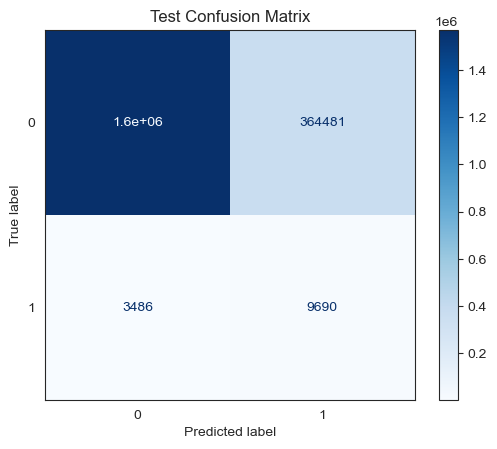

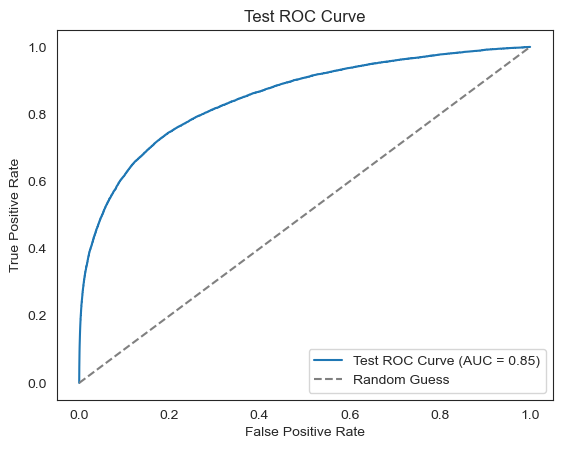

In [17]:
# -----------------------------------------------------------
# 4. 테스트 데이터 평가
# -----------------------------------------------------------
# 테스트 데이터 예측
# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_test = test.drop(columns=['churn'])
y_test = test['churn']

test_predictions = lgbm_model.predict(X_test)
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, test_predictions)
test_auc = roc_auc_score(y_test, test_probabilities)

print("\nTest Performance:")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test AUC-ROC: {test_auc:.2f}")
print(classification_report(y_test, test_predictions))

# Confusion Matrix 시각화
cm_test = confusion_matrix(y_test, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lgbm_model.classes_)
disp_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

FP를 희생하고, FN의 값을 소폭 줄이고, TP의 값을 소폭 증가시켰음.

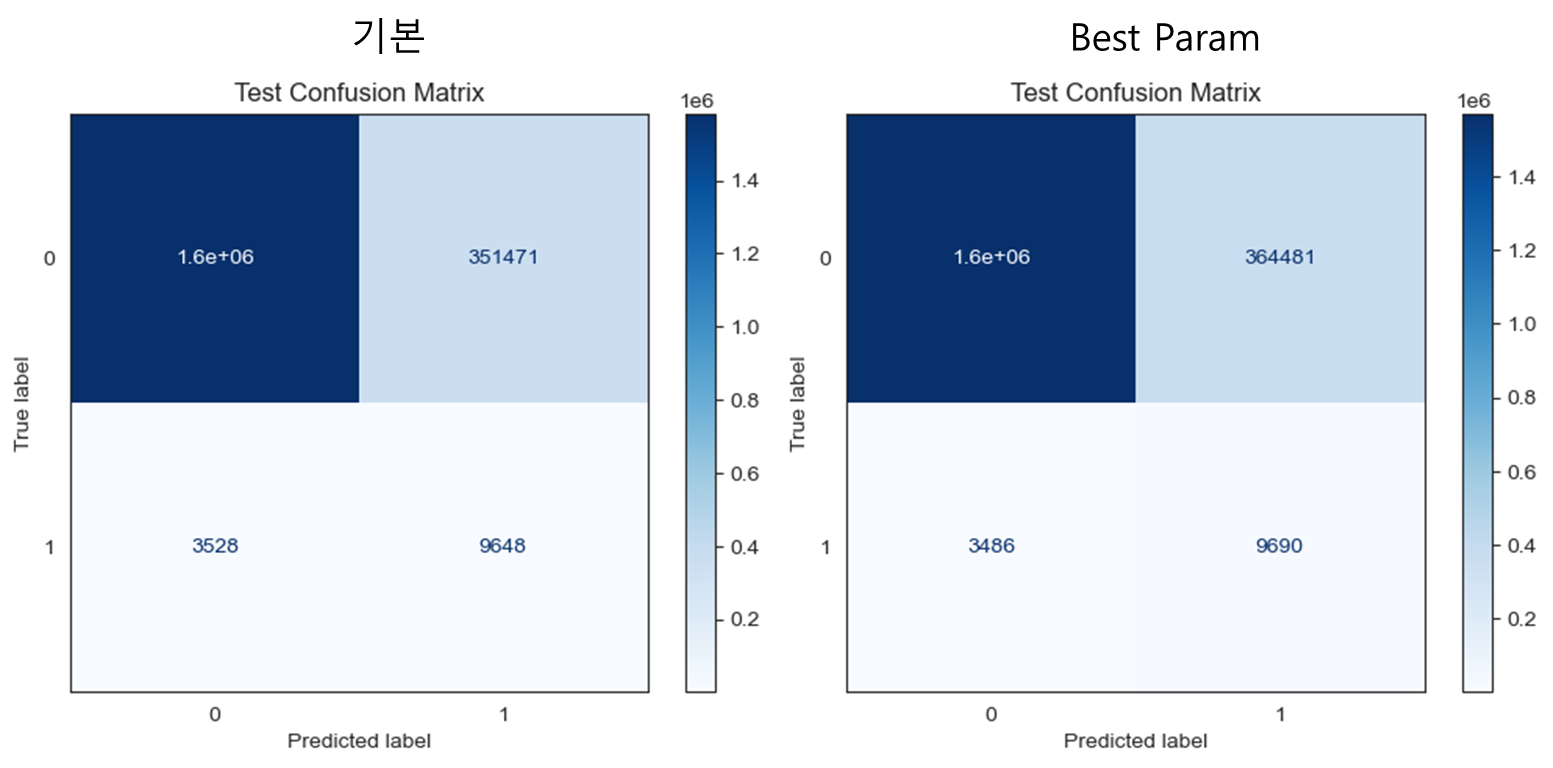

#### 📌 Optuna Best Parameters (LightGBM)

Optuna를 사용하여 찾은 LightGBM 모델의 최적 하이퍼파라미터

##### 🔹 최적의 하이퍼파라미터 값
| 하이퍼파라미터 | 최적 값 |
|--------------|-----------------------------|
| **n_estimators** | 994  |
| **learning_rate** | 0.1138  |
| **num_leaves** | 69  |
| **max_depth** | 2  |
| **min_child_samples** | 145  |
| **subsample** | 0.5077  |
| **colsample_bytree** | 0.7939  |
| **lambda_l1** | 4.6419  |
| **lambda_l2** | 9.1979  |